In [21]:
import sys
sys.path.append('..')
from data_module.data_utils import Processor

import numpy as np
import pandas as pd
import tifffile as tiff

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D



In [22]:
%%capture
%pip install Cython
%pip install hdbscan
%pip install umap-learn
%pip install umap-learn[plot]

import hdbscan
import umap
import umap.plot

# Object Oriented Database Creation 

In this notebook we will demonstrate usage of the **Processor** class to automate database generation. Here database creation requires two steps. 
1. Instantiate an instance of the **Processor** class and call the class method **get**. **get()** takes one argument, a list of properties for skimage to compute.
2. Call the methods **transform()** and **gen_df()** on the instance you instantiated in the last step

We can then use UMAP and HDBSCAN to find meaningful groupings within our dataset

In [18]:
props_list = props_list = ['area', 'solidity', 'perimeter_crofton', 'eccentricity', 'axis_major_length','axis_minor_length', 'perimeter', 'area_convex', 'area_filled', 'centroid_local', 'euler_number', 'extent', 'intensity_max', 'intensity_min']
x = Processor.get(props_list)
df = x.transform().gen_df()

In [19]:
clusterable_embedding = umap.UMAP(
    n_neighbors=30,
    min_dist=0.0,
    n_components=2,
    random_state=42,
).fit_transform(df)

labels = hdbscan.HDBSCAN(
    min_samples=10,
    min_cluster_size=500,
).fit_predict(clusterable_embedding)

labels_expanded = np.expand_dims(labels, axis = 1)
vmain_df_with_UMAP_labels = np.append(df, labels_expanded, axis = 1)


/Users/whoisv/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


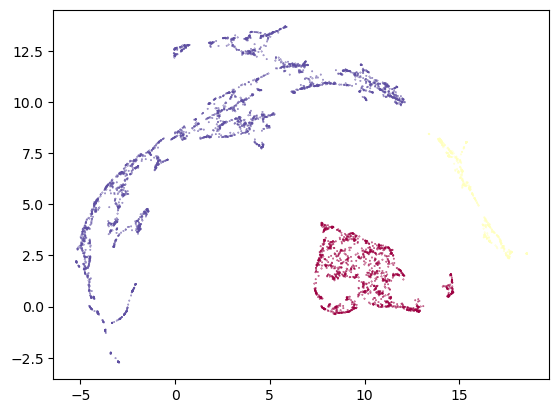

In [20]:
clustered = (labels >= 0)
plt.scatter(clusterable_embedding[~clustered, 0],
            clusterable_embedding[~clustered, 1],
            color=(0.5, 0.5, 0.5),
            s=0.1,
            alpha=0.5)
plt.scatter(clusterable_embedding[clustered, 0],
            clusterable_embedding[clustered, 1],
            c=labels[clustered],
            s=0.1,
            cmap='Spectral')

# SAM
The rest of this notebook will consist of experimentation with Facebook research's **SAM**

We start by ensuring that ROI's cropped using the DNA images properly overlay onto the Phase images

In [102]:
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


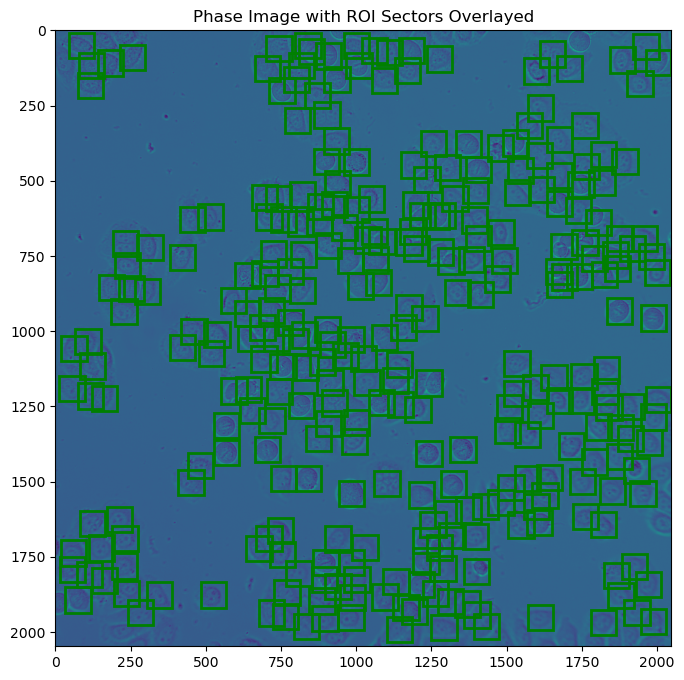

In [78]:
phase = tiff.imread('/Users/whoisv/cell_seg_classify/phase.tiff', key = 0)
fix, ax = plt.subplots(1, figsize = (8,8))
ax.imshow(phase)
ax.set_title('Phase Image with ROI Sectors Overlayed')

for i in range(301):
    box = x.coords[f'Frame_0_cell_{i}']
    show_box(box, ax)

plt.show()

In [50]:
%%capture
%pip install torch torchvision torchaudio
import torch as torch 

In [25]:
%pip install git+https://github.com/facebookresearch/segment-anything.git

  Cloning https://github.com/facebookresearch/segment-anything.git to /private/var/folders/86/mqcdsx050k17xm3qz7t5ysdc0000gn/T/pip-req-build-i7dkv2c7
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /private/var/folders/86/mqcdsx050k17xm3qz7t5ysdc0000gn/T/pip-req-build-i7dkv2c7
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36587 sha256=c52838e9fe40025d7e8668157c9933d41f0aa9165597c5a83ee119a8a777901a
  Stored in directory: /private/var/folders/86/mqcdsx050k17xm3qz7t5ysdc0000gn/T/pip-ephem-wheel-cache-3kr9anfi/wheels/15/d7/bd/05f5f23b7dcbe70cbc6783b06f12143b0cf1a5da5c7b52dcc5
Successfully built segment-anything
Note: you may need to restart the kernel to use updated packages.


In [31]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"


sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)


predictor = SamPredictor(sam)

In [93]:
boxes = torch.empty((301, 4))

for i in range(301):
    boxes[i] = torch.tensor(x.coords[f'Frame_0_cell_{i}'], device =sam.device)


In [94]:
processed_phase = (phase * 0.255) - phase.min()
ph2 = np.zeros( ( np.array(processed_phase).shape[0], np.array(processed_phase).shape[1], 3 ) )
ph2[:,:,0] = processed_phase
ph2[:,:,1] = processed_phase
ph2[:,:,2] = processed_phase
ph2 = ph2.astype('uint8')



In [100]:
predictor.set_image(ph2)
masks, _, _ = predictor.predict_torch(
    point_coords=None,
    point_labels=None,
    boxes=boxes,
    multimask_output=False,
)